In [43]:
# =========================
# Section 1 — Libraries & Utils
# =========================

# Core libs
import os, json, hashlib, pathlib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling / metrics / fairness / XAI
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, brier_score_loss
)
from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
import shap

# --- Utilities (no data touched) ---
def ensure_dir(path: str):
    """Create parent dirs for a file path if missing."""
    pathlib.Path(path).parent.mkdir(parents=True, exist_ok=True)

def file_hash(path: str) -> str:
    """MD5 of a file (for lightweight data lineage)."""
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def coerce_and_standardise_columns(df: pd.DataFrame,
                                   date="date", open_="open", high="high",
                                   low="low", close="close", volume="volume"):
    """Standardise OHLCV names to lowercase and sort by date."""
    # map any case to expected names
    lower = {c.lower(): c for c in df.columns}
    def pick(name): 
        if name in lower: return lower[name]
        raise KeyError(f"Missing column: {name}")
    df = df.rename(columns={
        pick(date): "date", pick(open_): "open", pick(high): "high",
        pick(low): "low", pick(close): "close", pick(volume): "volume"
    }).copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    return df.sort_values("date").dropna(subset=["date"]).reset_index(drop=True)

def build_target_and_groups(df: pd.DataFrame):
    """Add next_day_up target + volume/volatility tercile groups."""
    df = df.copy()
    df["next_close"] = df["close"].shift(-1)
    df["next_day_up"] = (df["next_close"] > df["close"]).astype(int)
    df = df.dropna(subset=["next_close"]).reset_index(drop=True)
    df["volatility"] = (df["high"] - df["low"]).abs()
    df["group_volume"] = pd.qcut(df["volume"].rank(method="first"), 3, labels=["low","med","high"])
    df["group_volatility"] = pd.qcut(df["volatility"].rank(method="first"), 3, labels=["low","med","high"])
    return df

def chronological_split_indices(n_rows: int, train_frac: float = 0.8):
    """Return (train_idx, test_idx) for a time-ordered split."""
    split = int(n_rows * train_frac)
    return np.arange(split), np.arange(split, n_rows)

def dataset_summary(df: pd.DataFrame, target_col: str, group_col: str,
                    train_idx: np.ndarray, test_idx: np.ndarray):
    """Print compact summary for appendix/audit."""
    tr_dates = df.iloc[train_idx]["date"]; te_dates = df.iloc[test_idx]["date"]
    sizes = pd.DataFrame({
        "set": ["train","test"],
        "rows": [len(train_idx), len(test_idx)],
        "date_range": [f"{tr_dates.min().date()} → {tr_dates.max().date()}",
                       f"{te_dates.min().date()} → {te_dates.max().date()}"],
        f"pos_rate({target_col}=1)": [
            round(df.iloc[train_idx][target_col].mean(),3),
            round(df.iloc[test_idx][target_col].mean(),3)
        ],
    })
    groups = (
        pd.DataFrame({
            "group": df.iloc[train_idx][group_col].value_counts().sort_index().index.tolist() +
                     df.iloc[test_idx][group_col].value_counts().sort_index().index.tolist(),
            "count": df.iloc[train_idx][group_col].value_counts().sort_index().values.tolist() +
                     df.iloc[test_idx][group_col].value_counts().sort_index().values.tolist(),
            "set":   ["train"]*df.iloc[train_idx][group_col].nunique() +
                     ["test"]*df.iloc[test_idx][group_col].nunique()
        }).pivot(index="group", columns="set", values="count").fillna(0).astype(int)
    )
    print("=== DATASET SUMMARY ===")
    print(sizes.to_string(index=False))
    print(f"\nGroup distribution by set ({group_col}):")
    print(groups)
    print("\nIndex ranges:",
          f"train {train_idx.min()}–{train_idx.max()} (n={len(train_idx)})  |  "
          f"test {test_idx.min()}–{test_idx.max()} (n={len(test_idx)})")
    return sizes, groups


In [44]:
# =========================
# Section 2 — Data Load, Target/Groups, Split, Summary
# =========================

# --- Config (adjust path + which sensitive group to use) ---
DATA_PATH = "sp500_clean.csv"          # <-- set to your CSV
SENSITIVE_GROUP_COL = "group_volatility"   # or "group_volume"
FEATURES = ["open","high","low","volume"]
TARGET = "next_day_up"
TRAIN_FRAC = 0.80

# --- Load & prepare ---
assert os.path.exists(DATA_PATH), f"DATA_PATH not found: {DATA_PATH}"
raw = pd.read_csv(DATA_PATH)
df = coerce_and_standardise_columns(raw)
df = build_target_and_groups(df)

# --- Chronological split ---
train_idx, test_idx = chronological_split_indices(len(df), train_frac=TRAIN_FRAC)

# --- Summary printout ---
_ = dataset_summary(df, target_col=TARGET, group_col=SENSITIVE_GROUP_COL,
                    train_idx=train_idx, test_idx=test_idx)

# --- Build train/test matrices for the model ---
X_train = df.iloc[train_idx][FEATURES].copy()
y_train = df.iloc[train_idx][TARGET].astype(int).copy()
X_test  = df.iloc[test_idx][FEATURES].copy()
y_test  = df.iloc[test_idx][TARGET].astype(int).copy()

print("\nShapes:", X_train.shape, y_train.shape, "|", X_test.shape, y_test.shape)
print("Sensitive feature:", SENSITIVE_GROUP_COL)


=== DATASET SUMMARY ===
  set  rows              date_range  pos_rate(next_day_up=1)
train  1005 2020-01-02 → 2023-12-28                    0.529
 test   252 2023-12-29 → 2024-12-30                    0.567

Group distribution by set (group_volatility):
set    test  train
group             
high     77    342
low      84    335
med      91    328

Index ranges: train 0–1004 (n=1005)  |  test 1005–1256 (n=252)

Shapes: (1005, 4) (1005,) | (252, 4) (252,)
Sensitive feature: group_volatility


In [45]:
# =========================
# Section 3 — Baseline Model: Train + Evaluate
# =========================

# --- Train baseline LightGBM model ---
model = LGBMClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=5, num_leaves=31,
    subsample=0.9, colsample_bytree=0.9, random_state=42
)
model.fit(X_train, y_train)

# --- Predict ---
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# --- Core metrics ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_prob)

print("=== BASELINE METRICS ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"Brier    : {brier:.3f}")


[LightGBM] [Info] Number of positive: 532, number of negative: 473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1005, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529353 -> initscore=0.117548
[LightGBM] [Info] Start training from score 0.117548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

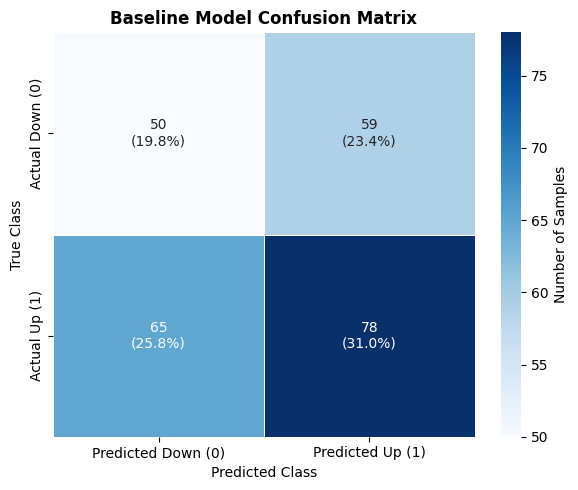

In [46]:
# =========================
# Section 4 — Confusion Matrix (Baseline Model)
# =========================
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", labels=("Down (0)", "Up (1)")):
    """Readable confusion matrix with counts + percentages."""
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = cm.sum()
    cm_perc = (cm / cm_sum) * 100.0

    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c, p = cm[i, j], cm_perc[i, j]
            annot[i, j] = f"{c}\n({p:.1f}%)"

    cm_df = pd.DataFrame(
        cm,
        index=[f"Actual {labels[0]}", f"Actual {labels[1]}"],
        columns=[f"Predicted {labels[0]}", f"Predicted {labels[1]}"]
    )

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=annot, fmt="", cmap="Blues",
                cbar_kws={"label": "Number of Samples"}, linewidths=0.5)
    plt.title(title, fontsize=12, weight="bold")
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.tight_layout()
    plt.show()

# --- Plot baseline confusion matrix ---
plot_confusion_matrix(y_test, y_pred, title="Baseline Model Confusion Matrix")


In [47]:
# =========================
# Section 5 — Fairness Mitigation (DP) + Gap Summary
# =========================
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Sensitive features (aligned)
sensitive_train = df.iloc[train_idx][SENSITIVE_GROUP_COL].astype(str).reset_index(drop=True)
sensitive_test  = df.iloc[test_idx][SENSITIVE_GROUP_COL].astype(str).reset_index(drop=True)

# Fit fairness mitigator
constraint = DemographicParity()
mitigator = ExponentiatedGradient(estimator=model, constraints=constraint)
mitigator.fit(X_train, y_train, sensitive_features=sensitive_train)

# Predictions (fairness-aware)
y_pred_fair = mitigator.predict(X_test).astype(int)

# MetricFrames (before & after), then only compute the DP gaps here
mf_base = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
).by_group.copy()

mf_fair = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred_fair, sensitive_features=sensitive_test
).by_group.copy()

report = mf_base.rename(columns={"accuracy":"accuracy_base","selection_rate":"sel_rate_base"}).join(
         mf_fair.rename(columns={"accuracy":"accuracy_fair","selection_rate":"sel_rate_fair"}))

mu_base = report["sel_rate_base"].mean()
mu_fair = report["sel_rate_fair"].mean()
dp_gap_base = (report["sel_rate_base"] - mu_base).abs().max()
dp_gap_fair = (report["sel_rate_fair"] - mu_fair).abs().max()
delta_abs   = dp_gap_fair - dp_gap_base
delta_rel   = (delta_abs / dp_gap_base) if dp_gap_base != 0 else np.nan

print("=== FAIRNESS (Demographic Parity) — Gap Summary ===")
print(f"Baseline DP gap : {dp_gap_base:.4f}  ({dp_gap_base*100:.1f}%)")
print(f"Fair DP gap     : {dp_gap_fair:.4f}  ({dp_gap_fair*100:.1f}%)")
arrow = "↓" if delta_abs < 0 else ("↑" if delta_abs > 0 else "→")
rel_txt = f"{abs(delta_rel)*100:.1f}%" if not np.isnan(delta_rel) else "n/a"
print(f"Change          : {arrow} {abs(delta_abs):.4f}  ({rel_txt} relative)")


[LightGBM] [Info] Number of positive: 532, number of negative: 473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1005, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529353 -> initscore=0.117548
[LightGBM] [Info] Start training from score 0.117548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [48]:
# =========================
# Section 6 — Per-Group Table (Before vs After)
# =========================
# Uses 'report' from Section 5
view = report.copy()

# Format as % where helpful
for c in ["sel_rate_base","sel_rate_fair"]:
    view[c] = (view[c]*100).round(1).astype(str) + "%"

view["accuracy_base"] = (report["accuracy_base"]*100).round(1).astype(str) + "%"
view["accuracy_fair"] = (report["accuracy_fair"]*100).round(1).astype(str) + "%"

# Deviations from group mean (DP context), also as %
mu_base = report["sel_rate_base"].astype(float).mean()
mu_fair = report["sel_rate_fair"].astype(float).mean()
dev_base = (report["sel_rate_base"] - mu_base)*100
dev_fair = (report["sel_rate_fair"] - mu_fair)*100
view["dev_from_mean_base"] = dev_base.round(1).astype(str) + "%"
view["dev_from_mean_fair"] = dev_fair.round(1).astype(str) + "%"

# Display
print("=== Per-Group Selection Rate & Accuracy (Before vs After) ===")
print(view[["sel_rate_base","sel_rate_fair",
            "accuracy_base","accuracy_fair",
            "dev_from_mean_base","dev_from_mean_fair"]]
      .rename_axis("group").reset_index().to_string(index=False))

# Optional: save CSV for appendix
# view.rename_axis("group").reset_index().to_csv("artifacts/per_group_metrics.csv", index=False)


=== Per-Group Selection Rate & Accuracy (Before vs After) ===
group sel_rate_base sel_rate_fair accuracy_base accuracy_fair dev_from_mean_base dev_from_mean_fair
 high         49.4%         48.1%         41.6%         45.5%              -5.0%              -3.5%
  low         61.9%         58.3%         58.3%         59.5%               7.6%               6.8%
  med         51.6%         48.4%         51.6%         50.5%              -2.7%              -3.2%


In [67]:
# show plots inside the notebook AND save them
%matplotlib inline
import matplotlib.pyplot as plt

def show_and_save(fig, path, dpi=200):
    fig.tight_layout()
    fig.savefig(path, dpi=dpi)
    plt.show(fig)   # display inline


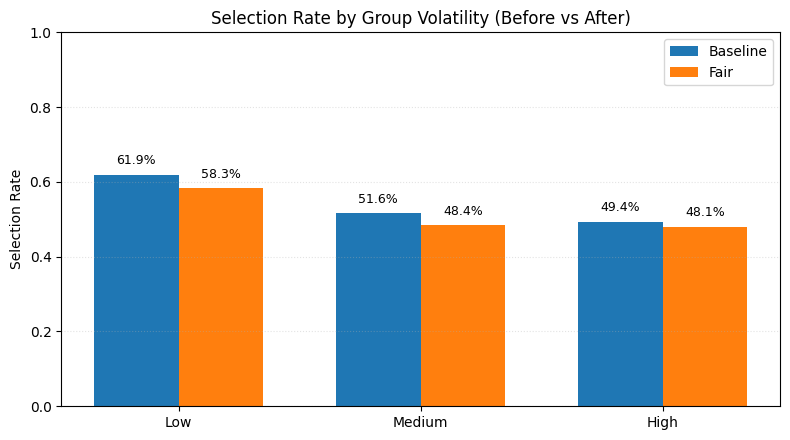

=== Selection Rate by Group (Before vs After) ===
 Group Selection Rate (Baseline) Selection Rate (Fair)
   Low                    61.90%                58.33%
Medium                    51.65%                48.35%
  High                    49.35%                48.05%


In [51]:
# =========================
# Section 7A — Selection Rates by Group (Before vs After)
# =========================
import numpy as np
import matplotlib.pyplot as plt

# ensure group labels on TEST are normalised
sens_test = (
    df.iloc[test_idx][SENSITIVE_GROUP_COL]
      .astype(str).str.lower().replace({"medium":"med","mid":"med","middle":"med"})
)

# get the two series in the correct order
target_order = ["low","med","high"]
present = [g for g in target_order if g in report.index]
sr_base = report.loc[present, "sel_rate_base"].values
sr_fair = report.loc[present, "sel_rate_fair"].values
labels  = {"low":"Low","med":"Medium","high":"High"}
groups  = [labels[g] for g in present]

x = np.arange(len(groups)); w = 0.35
fig, ax = plt.subplots(figsize=(8,4.5))
ax.bar(x - w/2, sr_base, width=w, label="Baseline")
ax.bar(x + w/2, sr_fair, width=w, label="Fair")
ax.set_xticks(x); ax.set_xticklabels(groups)
ax.set_ylabel("Selection Rate")
ax.set_ylim(0, 1.0)
ax.set_title(f"Selection Rate by {SENSITIVE_GROUP_COL.replace('_',' ').title()} (Before vs After)")
ax.grid(axis="y", linestyle=":", alpha=0.35)
ax.legend()

# value labels
for i,(b,f) in enumerate(zip(sr_base, sr_fair)):
    ax.text(i - w/2, b + 0.02, f"{b*100:.1f}%", ha="center", va="bottom", fontsize=9)
    ax.text(i + w/2, f + 0.02, f"{f*100:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
# plt.savefig("selection_rates_by_group.png", dpi=300)
plt.show()
# --- Print the exact selection-rate values used in the plot ---
print("=== Selection Rate by Group (Before vs After) ===")
sel_tbl = pd.DataFrame({
    "Group": groups,
    "Selection Rate (Baseline)": [f"{v*100:.2f}%" for v in sr_base],
    "Selection Rate (Fair)": [f"{v*100:.2f}%" for v in sr_fair]
})
print(sel_tbl.to_string(index=False))



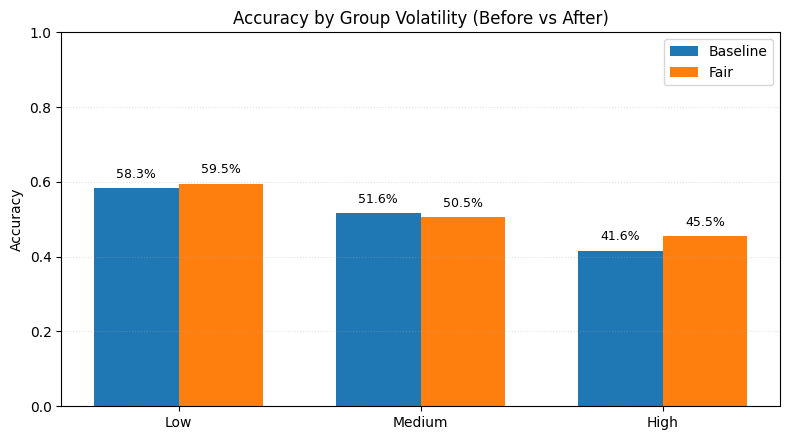

=== Accuracy by Group (Before vs After) ===
 Group Accuracy (Baseline) Accuracy (Fair)
   Low              58.33%          59.52%
Medium              51.65%          50.55%
  High              41.56%          45.45%


In [53]:
# =========================
# Section 7B — Accuracy by Group (Before vs After)
# =========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame

# recompute per-group accuracy from scratch (robust to missing groups)
sens_test = (
    df.iloc[test_idx][SENSITIVE_GROUP_COL]
      .astype(str).str.lower().replace({"medium":"med","mid":"med","middle":"med"})
)

mf_before = MetricFrame(metrics={"accuracy": accuracy_score},
                        y_true=y_test, y_pred=y_pred,
                        sensitive_features=sens_test).by_group
mf_after  = MetricFrame(metrics={"accuracy": accuracy_score},
                        y_true=y_test, y_pred=y_pred_fair,
                        sensitive_features=sens_test).by_group

target_order = ["low","med","high"]
present = [g for g in target_order if g in mf_before.index.union(mf_after.index)]
acc_base = mf_before.reindex(present)["accuracy"].values
acc_fair = mf_after.reindex(present)["accuracy"].values
labels   = {"low":"Low","med":"Medium","high":"High"}
groups   = [labels[g] for g in present]

x = np.arange(len(groups)); w = 0.35
fig, ax = plt.subplots(figsize=(8,4.5))
b1 = ax.bar(x - w/2, acc_base, width=w, label="Baseline")
b2 = ax.bar(x + w/2, acc_fair, width=w, label="Fair")
ax.set_xticks(x); ax.set_xticklabels(groups)
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1.0)
ax.set_title(f"Accuracy by {SENSITIVE_GROUP_COL.replace('_',' ').title()} (Before vs After)")
ax.grid(axis="y", linestyle=":", alpha=0.35)
ax.legend()

# value labels
for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h*100:.1f}%",
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
# plt.savefig("accuracy_by_group.png", dpi=300)
plt.show()

# --- Print the exact accuracy values used in the plot ---
print("=== Accuracy by Group (Before vs After) ===")
acc_tbl = pd.DataFrame({
    "Group": groups,
    "Accuracy (Baseline)": [f"{v*100:.2f}%" for v in acc_base],
    "Accuracy (Fair)": [f"{v*100:.2f}%" for v in acc_fair]
})
print(acc_tbl.to_string(index=False))



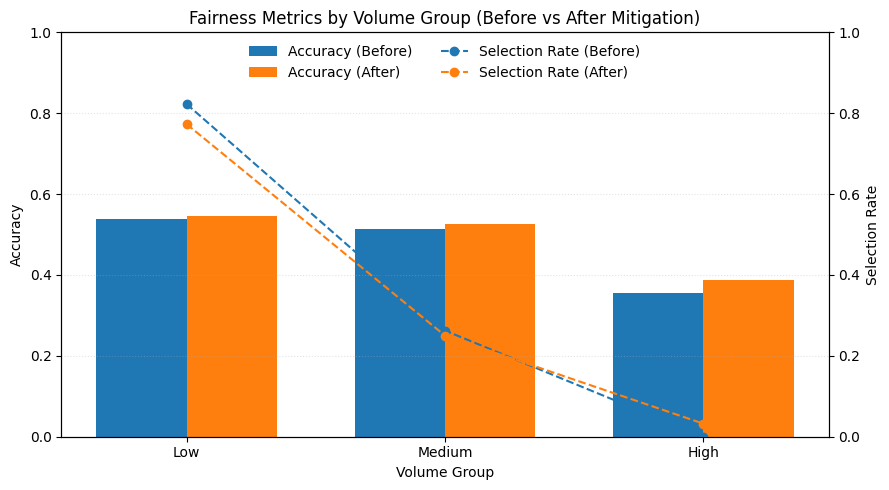

=== Fairness Metrics by Volume Group (Before vs After) ===
 Group Accuracy (Before) Accuracy (After) Selection (Before) Selection (After)
   Low            53.90%           54.61%             82.27%            77.30%
Medium            51.25%           52.50%             26.25%            25.00%
  High            35.48%           38.71%              0.00%             3.23%


In [57]:
# =========================
# Section 7C — Fairness Metrics by Volume Group (Before vs After)
# =========================
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sensitive feature for this figure: group_volume (normalize labels)
sens_vol_test = (
    df.iloc[test_idx]["group_volume"]
      .astype(str).str.lower().replace({"medium":"med","mid":"med","middle":"med"})
)

mf_before_v = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred, sensitive_features=sens_vol_test
).by_group.copy()

mf_after_v = MetricFrame(
    metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
    y_true=y_test, y_pred=y_pred_fair, sensitive_features=sens_vol_test
).by_group.copy()

order = ["low","med","high"]
present = [g for g in order if g in mf_before_v.index.union(mf_after_v.index)]
lab = {"low":"Low","med":"Medium","high":"High"}
groups = [lab[g] for g in present]

acc_base = mf_before_v.reindex(present)["accuracy"].values
acc_fair = mf_after_v.reindex(present)["accuracy"].values
sr_base  = mf_before_v.reindex(present)["selection_rate"].values
sr_fair  = mf_after_v.reindex(present)["selection_rate"].values

# --- Plot (Accuracy bars + Selection Rate lines)
x = np.arange(len(groups)); w = 0.35
fig, ax1 = plt.subplots(figsize=(9,5))

b1 = ax1.bar(x - w/2, acc_base, width=w, label="Accuracy (Before)")
b2 = ax1.bar(x + w/2, acc_fair, width=w, label="Accuracy (After)")
ax1.set_ylabel("Accuracy"); ax1.set_ylim(0,1.0)
ax1.set_xticks(x); ax1.set_xticklabels(groups); ax1.set_xlabel("Volume Group")
ax1.grid(axis="y", linestyle=":", alpha=0.35)

ax2 = ax1.twinx()
ax2.plot(x, sr_base, "o--", label="Selection Rate (Before)")
ax2.plot(x, sr_fair, "o--", label="Selection Rate (After)")
ax2.set_ylabel("Selection Rate"); ax2.set_ylim(0,1.0)

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper center", ncol=2, frameon=False)
plt.title("Fairness Metrics by Volume Group (Before vs After Mitigation)")
plt.tight_layout(); plt.show()

# --- Print table with exact values
tbl = pd.DataFrame({
    "Group": groups,
    "Accuracy (Before)":  [f"{v*100:.2f}%" for v in acc_base],
    "Accuracy (After)":   [f"{v*100:.2f}%" for v in acc_fair],
    "Selection (Before)": [f"{v*100:.2f}%" for v in sr_base],
    "Selection (After)":  [f"{v*100:.2f}%" for v in sr_fair],
})
print("=== Fairness Metrics by Volume Group (Before vs After) ===")
print(tbl.to_string(index=False))


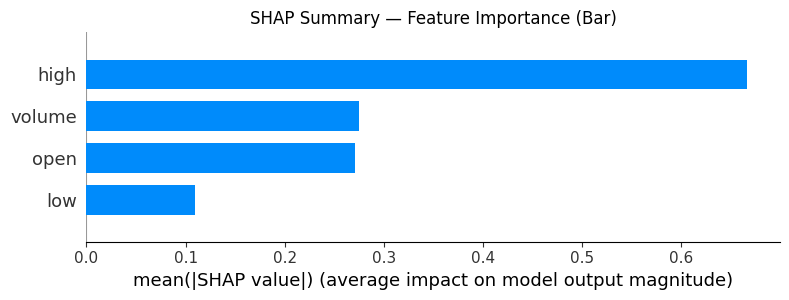

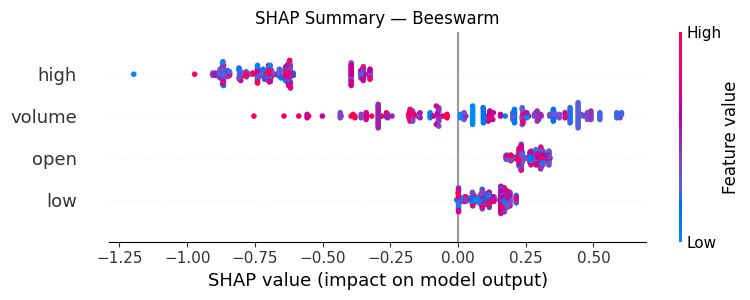

=== SHAP Global Importance (Mean |SHAP| on Test) ===
Feature  Mean |SHAP|
   high     0.666500
 volume     0.274913
   open     0.270742
    low     0.109784


In [54]:
# =========================
# Section 8A — SHAP Explainability (Bar + Beeswarm) + Table
# =========================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Build explainer on the trained baseline model
explainer = shap.TreeExplainer(model)

# SHAP values for the TEST set (handle LightGBM binary format)
sv = explainer.shap_values(X_test)
sv = sv[1] if isinstance(sv, list) and len(sv) == 2 else sv  # binary safety

# --- Figures ---
# 1) Bar plot (global importance)
plt.figure()
shap.summary_plot(sv, X_test, feature_names=X_test.columns, plot_type="bar", show=False)
plt.title("SHAP Summary — Feature Importance (Bar)")
plt.tight_layout()
# plt.savefig("shap_summary_bar.png", dpi=300)
plt.show()

# 2) Beeswarm (direction & distribution)
plt.figure()
shap.summary_plot(sv, X_test, feature_names=X_test.columns, show=False)
plt.title("SHAP Summary — Beeswarm")
plt.tight_layout()
# plt.savefig("shap_beeswarm.png", dpi=300)
plt.show()

# --- Table: mean(|SHAP|) per feature ---
abs_mean = np.abs(sv).mean(axis=0)
shap_tbl = pd.DataFrame({
    "Feature": list(X_test.columns),
    "Mean |SHAP|": abs_mean
}).sort_values("Mean |SHAP|", ascending=False).reset_index(drop=True)

print("=== SHAP Global Importance (Mean |SHAP| on Test) ===")
print(shap_tbl.to_string(index=False))


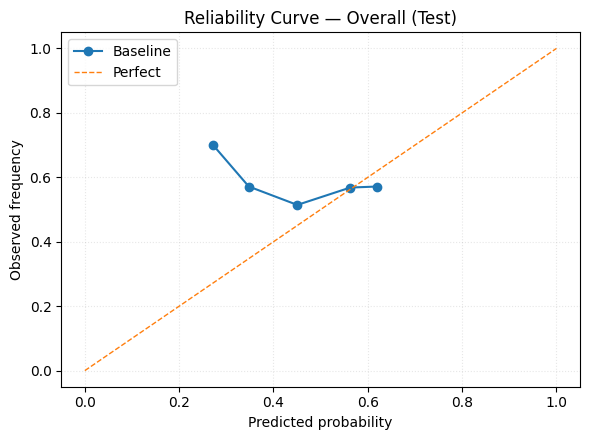

=== Calibration — Overall (10 bins) ===
 Bin  Mean Predicted  Mean Observed  Gap (Obs-Pred)
   1           0.272          0.700           0.428
   2           0.348          0.571           0.224
   3           0.451          0.514           0.064
   4           0.563          0.568           0.005
   5           0.621          0.571          -0.049


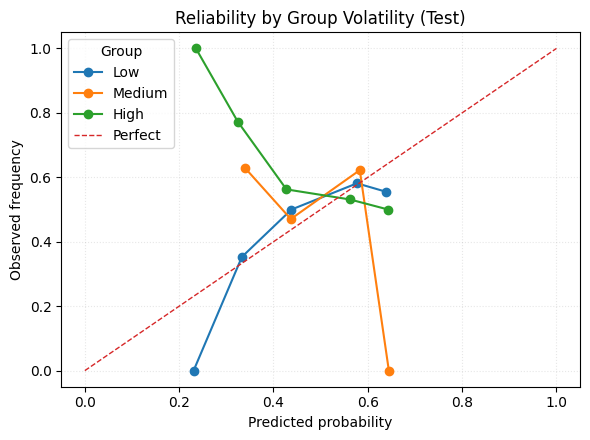

=== Calibration — Per Group (8 bins each; groups with >=20 samples) ===

-- Group: Low --
 Bin  Mean Predicted  Mean Observed  Gap (Obs-Pred)  Count in Bin (~)
   1           0.231          0.000          -0.231                16
   2           0.333          0.353           0.020                16
   3           0.438          0.500           0.062                16
   4           0.577          0.581           0.004                16
   5           0.638          0.556          -0.082                16

-- Group: Med --
 Bin  Mean Predicted  Mean Observed  Gap (Obs-Pred)  Count in Bin (~)
   1           0.339          0.630           0.290                22
   2           0.437          0.471           0.034                22
   3           0.583          0.622           0.039                22
   4           0.645          0.000          -0.645                22

-- Group: High --
 Bin  Mean Predicted  Mean Observed  Gap (Obs-Pred)  Count in Bin (~)
   1           0.236          1.0

In [55]:
# =========================
# Section 8B — Calibration / Reliability (Overall + Per-Group) + Tables
# =========================
from sklearn.calibration import calibration_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Overall calibration curve ---
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="uniform")

fig, ax = plt.subplots(figsize=(6,4.5))
ax.plot(prob_pred, prob_true, marker="o", label="Baseline")
ax.plot([0,1], [0,1], "--", lw=1, label="Perfect")
ax.set_xlabel("Predicted probability")
ax.set_ylabel("Observed frequency")
ax.set_title("Reliability Curve — Overall (Test)")
ax.legend()
ax.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
# plt.savefig("calibration_overall.png", dpi=300)
plt.show()

# Table for overall calibration
cal_overall_tbl = pd.DataFrame({
    "Bin": np.arange(1, len(prob_pred)+1),
    "Mean Predicted": np.round(prob_pred, 3),
    "Mean Observed":  np.round(prob_true, 3),
    "Gap (Obs-Pred)": np.round(prob_true - prob_pred, 3),
})
print("=== Calibration — Overall (10 bins) ===")
print(cal_overall_tbl.to_string(index=False))

# --- Per-group calibration curves (on TEST groups) ---
sens_test = (
    df.iloc[test_idx][SENSITIVE_GROUP_COL]
      .astype(str).str.lower().replace({"medium":"med","mid":"med","middle":"med"})
)
groups = ["low","med","high"]
present = [g for g in groups if g in sens_test.unique()]

fig, ax = plt.subplots(figsize=(6,4.5))
for g in present:
    idx = (sens_test.values == g)
    if idx.sum() < 20:  # skip tiny groups
        continue
    pt, pp = calibration_curve(y_test[idx], y_prob[idx], n_bins=8, strategy="uniform")
    ax.plot(pp, pt, marker="o", label={"low":"Low","med":"Medium","high":"High"}[g])
ax.plot([0,1],[0,1],"--", lw=1, label="Perfect")
ax.set_xlabel("Predicted probability")
ax.set_ylabel("Observed frequency")
ax.set_title(f"Reliability by {SENSITIVE_GROUP_COL.replace('_',' ').title()} (Test)")
ax.legend(title="Group")
ax.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
# plt.savefig("calibration_by_group.png", dpi=300)
plt.show()

# Tables per group
print("=== Calibration — Per Group (8 bins each; groups with >=20 samples) ===")
for g in present:
    idx = (sens_test.values == g)
    if idx.sum() < 20:
        continue
    pt, pp = calibration_curve(y_test[idx], y_prob[idx], n_bins=8, strategy="uniform")
    tbl = pd.DataFrame({
        "Bin": np.arange(1, len(pp)+1),
        "Mean Predicted": np.round(pp, 3),
        "Mean Observed":  np.round(pt, 3),
        "Gap (Obs-Pred)": np.round(pt - pp, 3),
        "Count in Bin (~)": int(idx.sum()/len(pp))  # rough count per bin
    })
    print(f"\n-- Group: {g.title()} --")
    print(tbl.to_string(index=False))


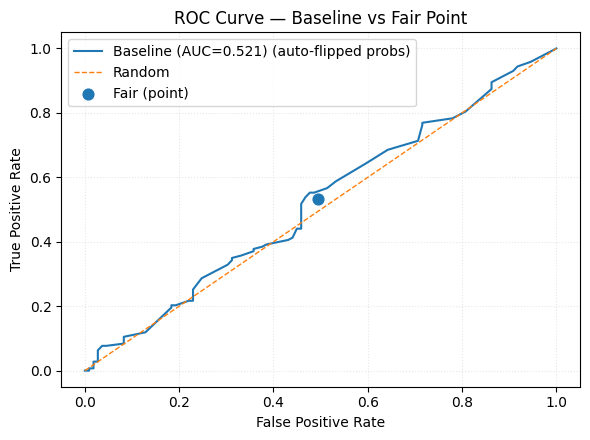

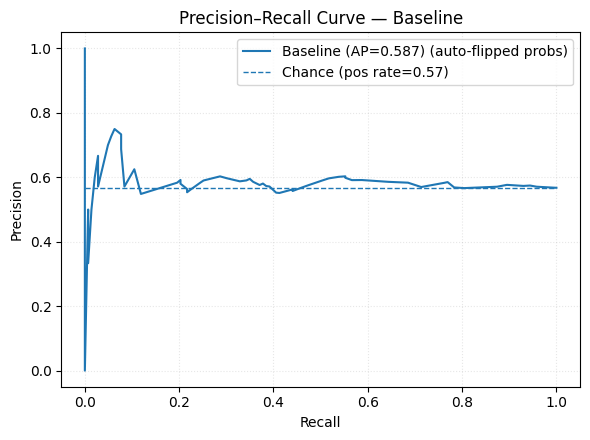

=== ROC Points (head) ===
  FPR   TPR  Threshold
0.000 0.000        inf
0.009 0.000      0.769
0.009 0.007      0.764
0.018 0.007      0.746
0.018 0.028      0.715
0.028 0.028      0.708
0.028 0.049      0.706
0.028 0.063      0.692
0.037 0.077      0.690
0.046 0.077      0.688

=== PR Points (head) ===
 Recall  Precision
  1.000      0.567
  0.993      0.568
  0.979      0.569
  0.958      0.571
  0.944      0.574
  0.930      0.573
  0.895      0.577
  0.881      0.573
  0.874      0.571
  0.804      0.567

AUC = 0.521 (auto-flipped probs) | Average Precision = 0.587 | Pos rate = 0.567
=== Threshold Sweep (Baseline probabilities) ===
 Threshold  Precision  Recall   FPR  Accuracy
       0.3      0.567   1.000 1.000     0.567
       0.5      0.565   0.455 0.459     0.492
       0.7      0.700   0.049 0.028     0.448


In [62]:
# =========================
# Section 9 — ROC & Precision–Recall (Baseline, robust)
# =========================
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
plt = matplotlib.pyplot  # ensure plt is the real pyplot

# --- Get probabilities for class=1 (with fallbacks) ---
if hasattr(model, "predict_proba"):
    cls_idx = list(model.classes_).index(1) if hasattr(model, "classes_") else 1
    y_prob = model.predict_proba(X_test)[:, cls_idx].astype(float)
else:
    # fallback: scale decision_function to [0,1] if available
    assert hasattr(model, "decision_function"), "Model has neither predict_proba nor decision_function."
    raw = model.decision_function(X_test).astype(float)
    y_prob = (raw - raw.min()) / (raw.max() - raw.min() + 1e-12)

# --- Auto-fix class-order inversion if needed ---
auc_orig = roc_auc_score(y_test, y_prob)
auc_flip = roc_auc_score(y_test, 1 - y_prob)
if auc_flip > auc_orig:
    y_prob = 1 - y_prob
    auc_used = auc_flip
    flip_note = " (auto-flipped probs)"
else:
    auc_used = auc_orig
    flip_note = ""

# --- ROC & PR calculations ---
fpr, tpr, thr = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

prec, rec, thr_pr = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
pos_rate = float(np.mean(y_test))  # chance level for PR

# --- ROC plot (baseline curve + fair point) ---
fig1, ax1 = plt.subplots(figsize=(6,4.5))
ax1.plot(fpr, tpr, label=f"Baseline (AUC={roc_auc:.3f}){flip_note}")
ax1.plot([0,1], [0,1], "--", lw=1, label="Random")
# Fair point (only if denominators >0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fair).ravel()
fpr_fair = fp / (fp + tn) if (fp + tn) > 0 else np.nan
tpr_fair = tp / (tp + fn) if (tp + fn) > 0 else np.nan
if np.isfinite(fpr_fair) and np.isfinite(tpr_fair):
    ax1.scatter([fpr_fair], [tpr_fair], s=60, label="Fair (point)")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("ROC Curve — Baseline vs Fair Point")
ax1.legend()
ax1.grid(alpha=0.3, linestyle=":")
plt.tight_layout(); plt.show()

# --- PR plot (baseline curve + chance line) ---
fig2, ax2 = plt.subplots(figsize=(6,4.5))
ax2.plot(rec, prec, label=f"Baseline (AP={ap:.3f}){flip_note}")
ax2.hlines(pos_rate, 0, 1, linestyles="--", lw=1, label=f"Chance (pos rate={pos_rate:.2f})")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Precision–Recall Curve — Baseline")
ax2.legend()
ax2.grid(alpha=0.3, linestyle=":")
plt.tight_layout(); plt.show()

# --- Compact tables (heads) ---
roc_tbl = pd.DataFrame({"FPR": np.round(fpr,3), "TPR": np.round(tpr,3), "Threshold": np.round(thr,3)})
pr_tbl  = pd.DataFrame({"Recall": np.round(rec,3), "Precision": np.round(prec,3)})

print("=== ROC Points (head) ===")
print(roc_tbl.head(10).to_string(index=False))
print("\n=== PR Points (head) ===")
print(pr_tbl.head(10).to_string(index=False))
print(f"\nAUC = {roc_auc:.3f}{flip_note} | Average Precision = {ap:.3f} | Pos rate = {pos_rate:.3f}")

# =========================
# Threshold Sweep — Precision / Recall / FPR
# =========================
from sklearn.metrics import precision_score, recall_score, confusion_matrix

thresholds = [0.3, 0.5, 0.7]
rows = []
for thr in thresholds:
    y_pred_thr = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thr).ravel()
    prec = precision_score(y_test, y_pred_thr, zero_division=0)
    rec  = recall_score(y_test, y_pred_thr, zero_division=0)
    fpr  = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    acc  = (tp + tn) / (tp + tn + fp + fn)
    rows.append([thr, round(prec,3), round(rec,3), round(fpr,3), round(acc,3)])

thresh_tbl = pd.DataFrame(rows, columns=["Threshold","Precision","Recall","FPR","Accuracy"])
print("=== Threshold Sweep (Baseline probabilities) ===")
print(thresh_tbl.to_string(index=False))


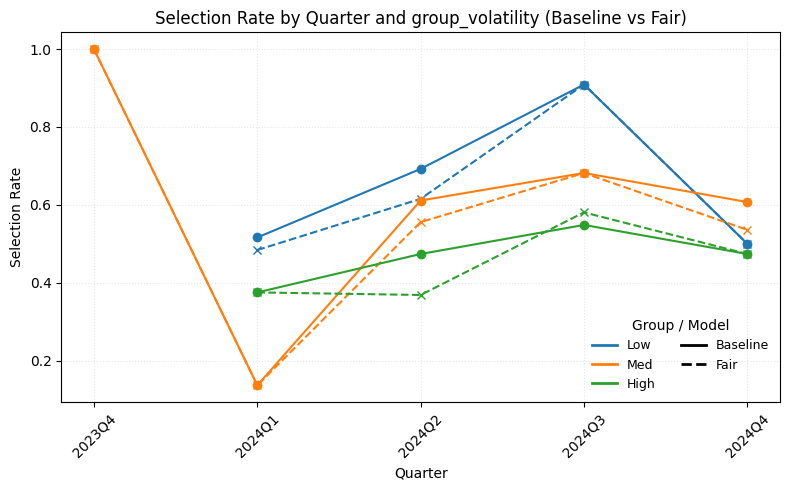

=== Selection Rate by Quarter and Group ===
group_volatility    low    med   high    low    med   high
type               base   base   base   fair   fair   fair
Quarter                                                   
2023Q4              NaN  1.000    NaN    NaN  1.000    NaN
2024Q1            0.516  0.136  0.375  0.484  0.136  0.375
2024Q2            0.692  0.611  0.474  0.615  0.556  0.368
2024Q3            0.909  0.682  0.548  0.909  0.682  0.581
2024Q4            0.500  0.607  0.474  0.500  0.536  0.474


In [66]:
# =========================
# Section 13 — Fairness Stability (clean legend)
# =========================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df["Quarter"] = pd.PeriodIndex(df["date"], freq="Q").astype(str)
sensitive_col = "group_volatility"   # or group_volume
temp = df.iloc[test_idx].copy()
temp["y_pred_base"] = y_pred
temp["y_pred_fair"] = y_pred_fair

sr_time_base = temp.groupby(["Quarter", sensitive_col])["y_pred_base"].mean().reset_index()
sr_time_fair = temp.groupby(["Quarter", sensitive_col])["y_pred_fair"].mean().reset_index()
sr_time_base["type"] = "base"
sr_time_fair["type"] = "fair"
sr_all = pd.concat([sr_time_base, sr_time_fair]).rename(columns={"y_pred_base":"sel_rate","y_pred_fair":"sel_rate"})

fig, ax = plt.subplots(figsize=(8,5))
colors = {"low":"tab:blue","med":"tab:orange","high":"tab:green"}
linestyles = {"base":"-","fair":"--"}
markers = {"base":"o","fair":"x"}

# draw all lines
for g in ["low","med","high"]:
    for t in ["base","fair"]:
        subset = sr_all[(sr_all[sensitive_col]==g) & (sr_all["type"]==t)]
        if subset.empty:
            continue
        ax.plot(subset["Quarter"], subset["sel_rate"],
                linestyle=linestyles[t], marker=markers[t],
                color=colors[g], label=f"{g} ({t})")

ax.set_ylabel("Selection Rate")
ax.set_xlabel("Quarter")
ax.set_title(f"Selection Rate by Quarter and {sensitive_col} (Baseline vs Fair)")
ax.grid(alpha=0.3, linestyle=":")
plt.xticks(rotation=45)
plt.tight_layout()

# --- custom legend: one per group with line style samples ---
from matplotlib.lines import Line2D
legend_elements = []
for g,c in colors.items():
    legend_elements.append(Line2D([0],[0], color=c, lw=2, label=g.title()))
legend_elements.append(Line2D([0],[0], color="black", lw=2, linestyle="-", label="Baseline"))
legend_elements.append(Line2D([0],[0], color="black", lw=2, linestyle="--", label="Fair"))
ax.legend(handles=legend_elements, ncol=2, frameon=False, fontsize=9, title="Group / Model")

plt.show()

# --- print table for appendix ---
print("=== Selection Rate by Quarter and Group ===")
sr_pivot = sr_all.pivot_table(index=["Quarter"], columns=[sensitive_col,"type"], values="sel_rate")
print(np.round(sr_pivot,3).to_string())


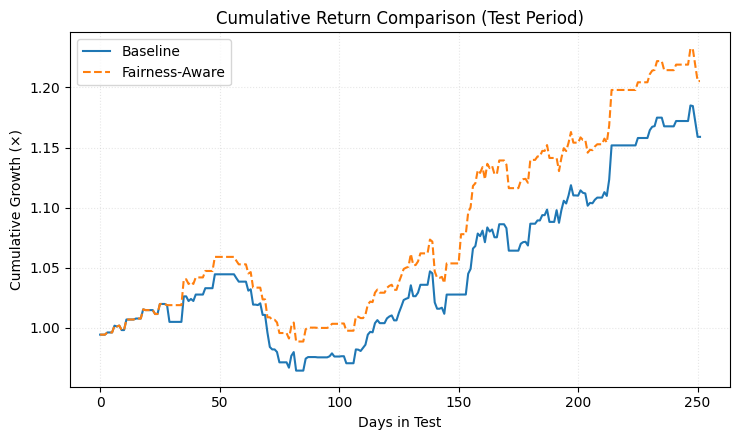

=== Cumulative Return — Summary (Test) ===
   Model Final Growth (×) Total Return (%) Days Invested (%)  Signal Switches
Baseline            1.159             15.9              54.4               86
    Fair            1.205             20.5              51.6               94


In [63]:
# =========================
# Section 10 — Simple Cumulative Return Comparison (Baseline vs Fair)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Build next-day returns for the TEST window ---
close_test = df.iloc[test_idx]["close"].values
daily_ret  = np.diff(close_test) / close_test[:-1]        # next-day return
daily_ret  = np.append(daily_ret, 0.0)                    # pad to align length

# --- Signals (1 = invest for next day’s move, 0 = stay out) ---
sig_base = y_pred.astype(int)
sig_fair = y_pred_fair.astype(int)

# --- Helper: simple equity curve (optional fee on signal changes) ---
def equity_curve(signal, ret, fee_bps=0.0):
    signal = np.asarray(signal, dtype=int)
    ret = np.asarray(ret, dtype=float)
    # trade when signal changes (enter/exit)
    flips = np.abs(np.diff(np.r_[signal[0], signal])) > 0
    costs = np.zeros_like(ret)
    costs[flips] = fee_bps / 10000.0
    pnl = signal * ret - costs
    return (1 + pnl).cumprod(), flips.sum()

eq_base, flips_base = equity_curve(sig_base, daily_ret, fee_bps=0.0)  # set 5.0 for 5 bps if you like
eq_fair, flips_fair = equity_curve(sig_fair, daily_ret, fee_bps=0.0)

# --- Plot ---
plt.figure(figsize=(7.5, 4.5))
plt.plot(eq_base, label="Baseline")
plt.plot(eq_fair, label="Fairness-Aware", linestyle="--")
plt.title("Cumulative Return Comparison (Test Period)")
plt.xlabel("Days in Test")
plt.ylabel("Cumulative Growth (×)")
plt.grid(alpha=0.3, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# --- Summary table (simple, human-readable) ---
def summarize_curve(name, eq, signal, flips):
    growth = float(eq[-1])
    total_ret = (growth - 1.0) * 100
    sel_rate = signal.mean() * 100
    return {
        "Model": name,
        "Final Growth (×)": f"{growth:.3f}",
        "Total Return (%)": f"{total_ret:.1f}",
        "Days Invested (%)": f"{sel_rate:.1f}",
        "Signal Switches": int(flips),
    }

summary_tbl = pd.DataFrame([
    summarize_curve("Baseline", eq_base, sig_base, flips_base),
    summarize_curve("Fair",     eq_fair, sig_fair, flips_fair),
])

print("=== Cumulative Return — Summary (Test) ===")
print(summary_tbl.to_string(index=False))

# Optional: save for appendix
# summary_tbl.to_csv("artifacts/cumulative_return_summary.csv", index=False)


In [64]:
# =========================
# Section 11 — Summary Dashboard
# =========================
summary = pd.DataFrame({
    "Metric": [
        "Baseline Accuracy", "Fair Accuracy",
        "Baseline DP gap", "Fair DP gap",
        "AUC", "Average Precision",
        "Final Growth (Baseline)", "Final Growth (Fair)"
    ],
    "Value": [
        f"{accuracy_score(y_test, y_pred):.3f}",
        f"{accuracy_score(y_test, y_pred_fair):.3f}",
        f"{dp_gap_base:.3f}",
        f"{dp_gap_fair:.3f}",
        f"{roc_auc:.3f}",
        f"{ap:.3f}",
        f"{float(summary_tbl.loc[0,'Final Growth (×)']):.3f}",
        f"{float(summary_tbl.loc[1,'Final Growth (×)']):.3f}",
    ]
})
print("=== OVERALL SUMMARY ===")
print(summary.to_string(index=False))


=== OVERALL SUMMARY ===
                 Metric Value
      Baseline Accuracy 0.508
          Fair Accuracy 0.520
        Baseline DP gap 0.076
            Fair DP gap 0.068
                    AUC 0.521
      Average Precision 0.587
Final Growth (Baseline) 1.159
    Final Growth (Fair) 1.205
